# [자전거 공유 수요](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
워싱턴D.C 소재의 자전거 대여 스타트업의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표!!

## 평가지표 - RMSLE
- Root Mean Squared Logarithmic Error
- 잔차(residual)에 대한 평균에 로그를 씌운 값
- 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
- 정답에 대한 오류를 숫자로 나타낸 값이 클 수록 오차가 크다는 의미이다.
  - 즉, 값이 작을 수록 오류가 적다는 의미를 나타낸다.

$$ RMSLE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1)-log(y\hat{}_{i}+1))^2}$$

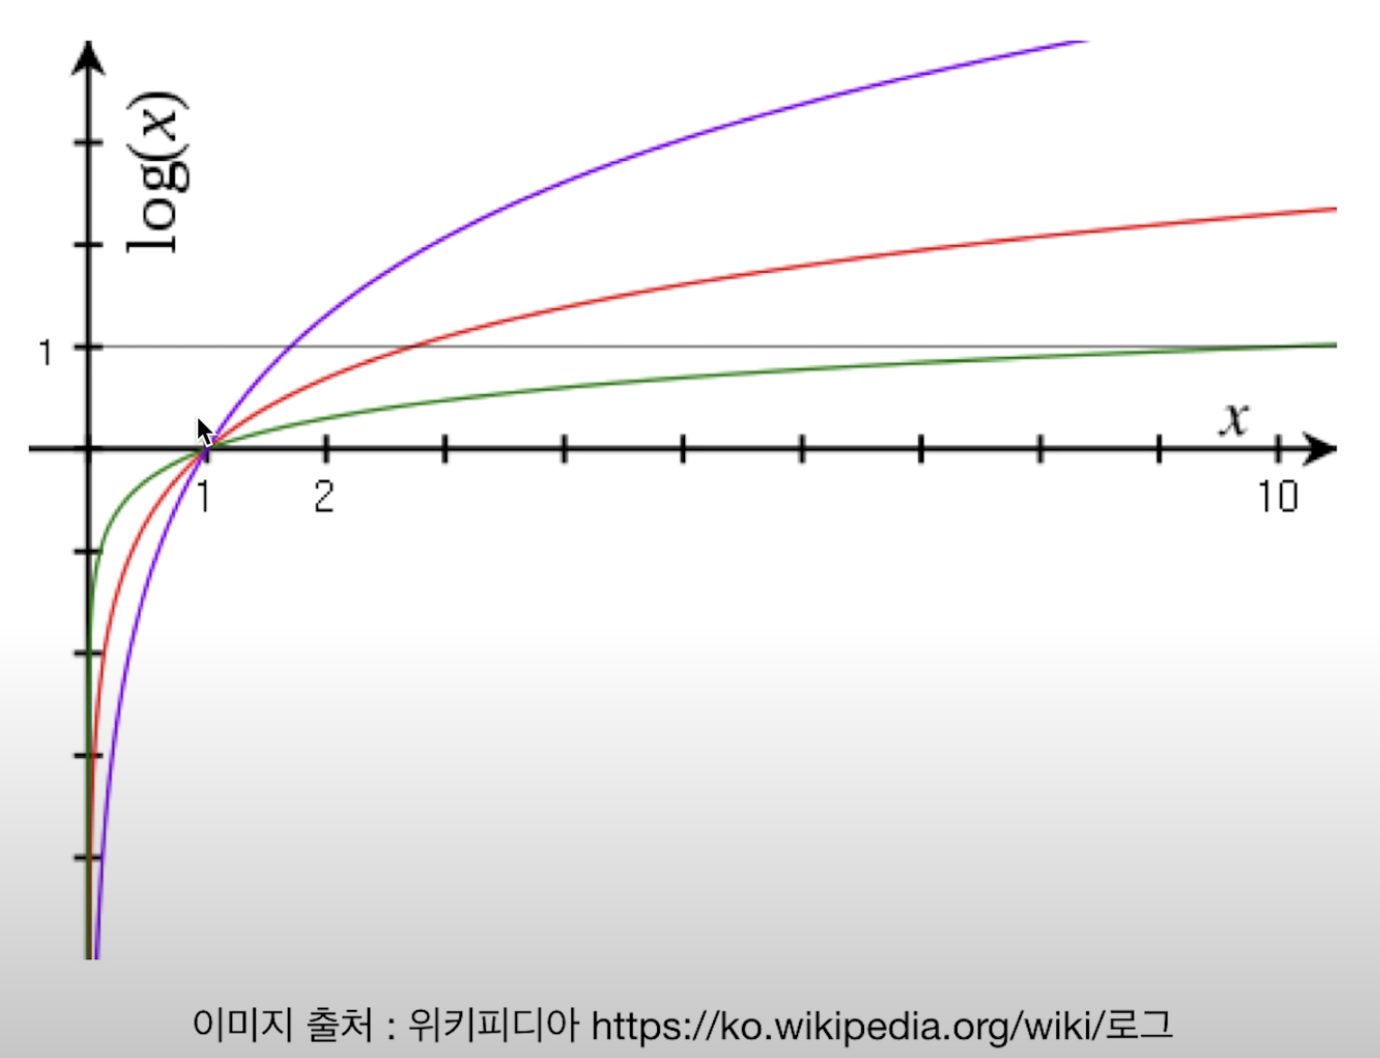

In [2]:
import numpy as np

def rmsle(y, pred, convertExp=False):
    if convertExp:
        y = np.exp(y)
        pred = np.exp(pred)

    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in pred]))
    calc = (log1 - log2)**2

    return np.sqrt(np.mean(calc))

In [3]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## [Data 설명](https://www.kaggle.com/competitions/bike-sharing-demand/data?select=sampleSubmission.csv)

### Features

- datetime:  
  - hourly date + timestamp  
- season(계절):  
  - 1 = spring
  - 2 = summer
  - 3 = fall
  - 4 = winter
- holiday(휴일):  
  - whether the day is considered a holiday
- workingday(근무일):
  - whether the day is neither a weekend nor holiday
- weather(날씨):
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp(온도):
  - temperature in Celsius
- atemp(체감온도):
  - "feels like" temperature in Celsius
- humidity(습도):
  - relative humidity
- windspeed(풍속):
  - wind speed

### Target

- count:
  - 총 대여 수
  - number of total rentals

참고용
- casual:
  - 미등록 사용자 대여 개시 수
  - number of non-registered user rentals initiated
- registered:
  - 등록 사용자 대여 개시
  -  number of registered user rentals initiated

# Global Variables

In [253]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_baseModel_{0:.5f}.csv'

args.SEED = 42
args.target_col = 'count'

args.result_list = []

# Import Library

In [5]:
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [6]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

from lightgbm import LGBMRegressor, LGBMClassifier, plot_importance

# 데이터 분리
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
import shap

# warning
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
import random
import numpy as np

def reset_seeds(seed=args.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)

reset_seeds()

In [8]:
def predict_windspeed(p_train, p_test):
    print(f'before: {p_train.shape} / {p_test.shape}')

    train_wind0 = p_train.loc[p_train['windspeed'] == 0]
    train_wind_not0 = p_train.loc[p_train['windspeed'] != 0]
    test_wind0 = p_test.loc[p_test['windspeed'] == 0]
    test_wind_not0 = p_test.loc[p_test['windspeed'] != 0]

    wind_cols = list(abs(p_train.corr())['windspeed'].sort_values().index)
    wind_cols.remove('count')
    wind_cols.remove('windspeed')
    print(f'len(wind_cols): {len(wind_cols)}')

    # training
    train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')
    wind_model = LGBMClassifier(random_state=args.SEED, verbose= False)
    wind_model.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    score = wind_model.score(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    print(f'score: {score}')

    # predict
    train_wind0['windspeed'] = wind_model.predict(train_wind0[wind_cols])
    test_wind0['windspeed'] = wind_model.predict(test_wind0[wind_cols])

    # concat
    train = train_wind_not0.append(train_wind0).sort_values(by=['datetime'])
    train['windspeed'] = train['windspeed'].astype('float')
    train.reset_index(drop=True, inplace=True)
    test = test_wind_not0.append(test_wind0).sort_values(by=['datetime'])
    test['windspeed'] = test['windspeed'].astype('float')
    test.reset_index(drop=True, inplace=True)

    print(f'after: {train.shape} / {test.shape}')
    return train, test

## Connect to google account

In [9]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


# Load Data

## train data

In [10]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### target

In [11]:
ori_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

## test data

In [12]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)
ori_test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


# Data Preprocessing

## 결측치 확인

In [13]:
ori_train.isnull().sum().sum()

0

In [14]:
ori_test.isnull().sum().sum()

0

## datetime 변수 추가

In [15]:
ori_train['datetime'] = pd.to_datetime(ori_train['datetime'])
ori_test['datetime'] = pd.to_datetime(ori_test['datetime'])

In [16]:
print(f'before: {ori_train.shape} / {ori_test.shape}')

for data in [ori_train, ori_test]:
  data['year'] = data['datetime'].dt.year # 년도
  data['month'] = data['datetime'].dt.month # 월
  data['day'] = data['datetime'].dt.day # 일
  data['dayofweek'] = data['datetime'].dt.dayofweek # 요일
  data['quarter'] = data['datetime'].dt.quarter # 분기
  data['hour'] = data['datetime'].dt.hour # 시간
  # data['minute'] = data['datetime'].dt.minute # 분
  # data['second'] = data['datetime'].dt.second # 초

  # data['weekend'] = data['dayofweek'].apply(lambda x: int(x in [5,6]))

print(f'after: {ori_train.shape} / {ori_test.shape}')

before: (10886, 12) / (6493, 9)
after: (10886, 18) / (6493, 15)


## 필요없는 컬럼 제거

- test에 없는 컬럼 제외

In [17]:
drop_cols = list(set(ori_train.columns) - set(ori_test.columns))
drop_cols.remove('count') # target 제외
drop_cols

['casual', 'registered']

In [18]:
print(f'before: {ori_train.shape}')
ori_train.drop(drop_cols, axis=1, inplace=True)
print(f'after: {ori_train.shape}')

before: (10886, 18)
after: (10886, 16)


- eda 분석을 통해 필요없는 컬럼 추가

In [19]:
drop_cols = ['holiday', 'season', 'quarter']
drop_cols

['holiday', 'season', 'quarter']

In [20]:
print(f'before: {ori_train.shape}')
ori_train.drop(drop_cols, axis=1, inplace=True)
ori_test.drop(drop_cols, axis=1, inplace=True)
print(f'after: {ori_train.shape}')

before: (10886, 16)
after: (10886, 13)


In [21]:
ori_train.head(2)

,datetime,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,0
1,2011-01-01 01:00:00,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1


In [22]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 13) / (6493, 12)


# base model

In [254]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 13) / (6493, 12)


In [255]:
train = ori_train.copy()
test = ori_test.copy()

train.shape, test.shape

((10886, 13), (6493, 12))

## Feature Selection

### drop cols

In [256]:
drop_cols = ['datetime']

print(f'before: {train.shape} / {test.shape}')
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)
print(f'after: {train.shape} / {test.shape}')

before: (10886, 13) / (6493, 12)
after: (10886, 12) / (6493, 11)


### convert categorical

In [257]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   workingday  10886 non-null  int64  
 1   weather     10886 non-null  int64  
 2   temp        10886 non-null  float64
 3   atemp       10886 non-null  float64
 4   humidity    10886 non-null  int64  
 5   windspeed   10886 non-null  float64
 6   count       10886 non-null  int64  
 7   year        10886 non-null  int64  
 8   month       10886 non-null  int64  
 9   day         10886 non-null  int64  
 10  dayofweek   10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1020.7 KB


In [258]:
train.describe()

,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,3.013963,11.541613
std,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,2.004585,6.915838
min,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,1.000000,6.000000
50%,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,3.000000,12.000000
75%,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,5.000000,18.000000
max,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,6.000000,23.000000


In [259]:
categorical_cols = [
    'workingday', 'weather', 'year', 'month', 'day', 'dayofweek', 'hour'
]

for col in categorical_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   workingday  10886 non-null  category
 1   weather     10886 non-null  category
 2   temp        10886 non-null  float64 
 3   atemp       10886 non-null  float64 
 4   humidity    10886 non-null  int64   
 5   windspeed   10886 non-null  float64 
 6   count       10886 non-null  int64   
 7   year        10886 non-null  category
 8   month       10886 non-null  category
 9   day         10886 non-null  category
 10  dayofweek   10886 non-null  category
 11  hour        10886 non-null  category
dtypes: category(7), float64(3), int64(2)
memory usage: 502.4 KB


In [260]:
train.shape, test.shape

((10886, 12), (6493, 11))

### split data

In [261]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 11), (10886,))

In [262]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 11), (2722, 11), (8164,), (2722,))

## modeling

In [263]:
reset_seeds()

base_model = LGBMRegressor(random_state=args.SEED)
base_model.fit(x_tr, y_tr)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 11
[LightGBM] [Info] Start training from score 191.339784


LGBMRegressor(random_state=42)

### prediction

In [264]:
reset_seeds()

score = base_model.score(x_tr, y_tr)

pred = base_model.predict(x_te)
rmsle_score = rmsle(y_te, pred)


print(f'{score:.2f} / {rmsle_score:.2f}')

0.97 / 0.43


<Axes: ylabel='Density'>

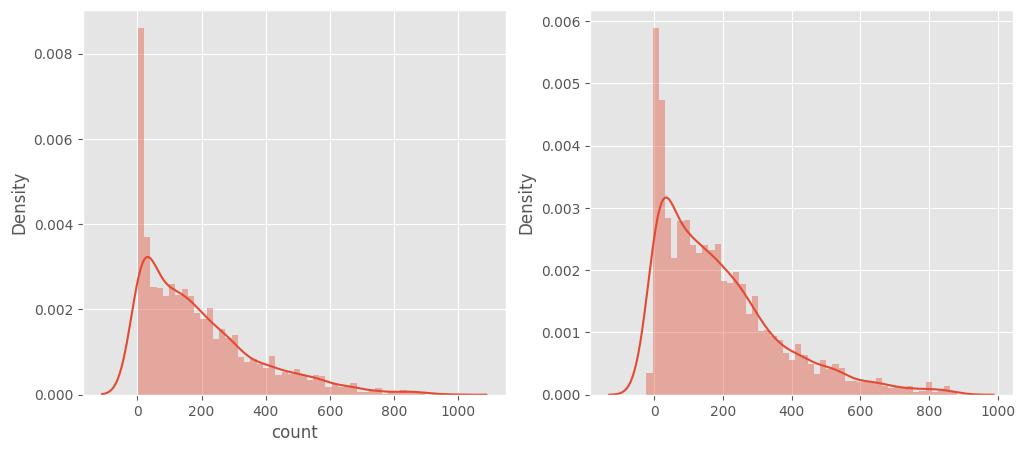

In [265]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pred, ax=ax2, bins=50)

Text(0, 0.5, 'prediction')

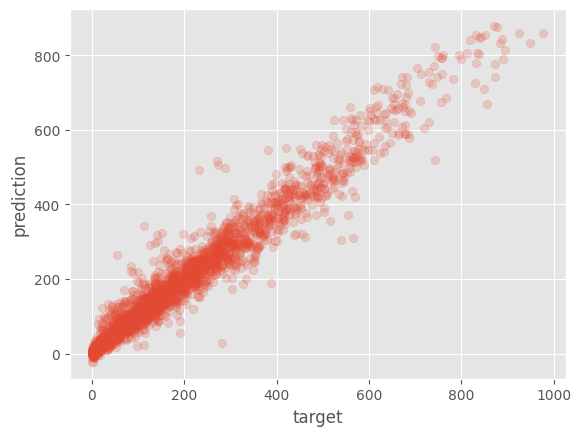

In [266]:
plt.scatter(y_te, pred, alpha=0.2)
plt.xlabel('target')
plt.ylabel('prediction')

### [plot_importance](https://www.rasgoml.com/feature-engineering-tutorials/how-to-generate-feature-importance-plots-using-catboost)

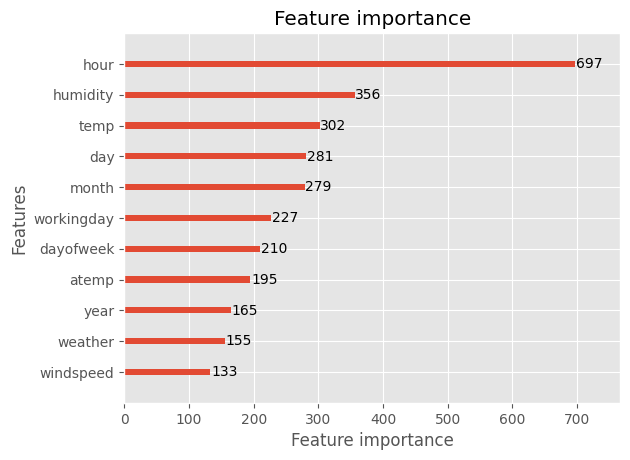

In [267]:
plot_importance(base_model)
plt.show()

Text(0.5, 1.0, 'Permutation Importance')

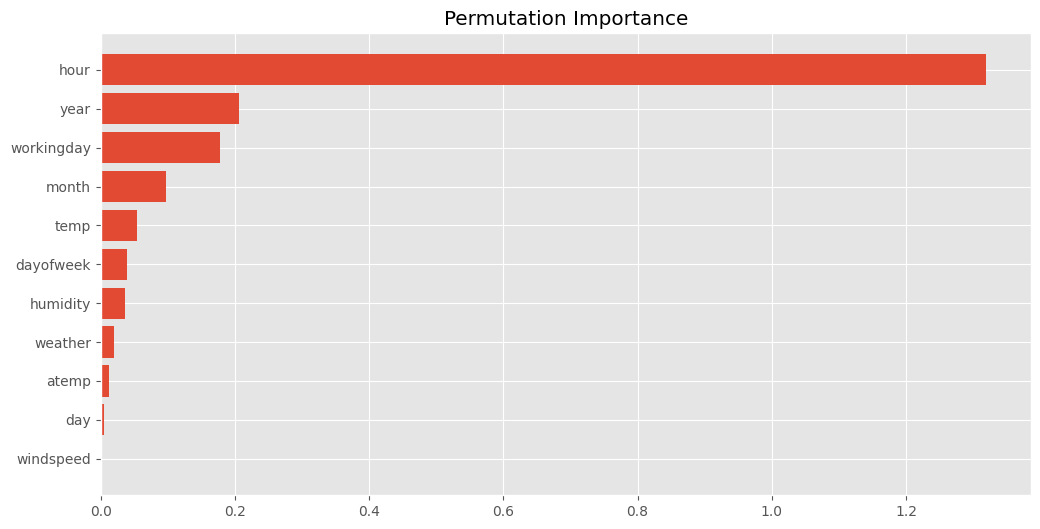

In [268]:
reset_seeds()

perm_importance = permutation_importance(base_model, x_te, y_te, n_repeats=10, random_state=args.SEED)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_te.columns)[sorted_idx])
plt.title('Permutation Importance')


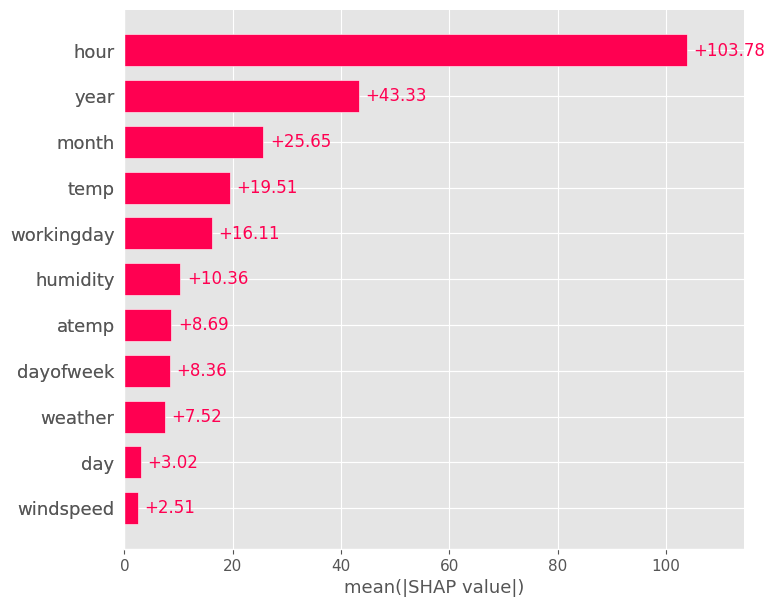

In [269]:
reset_seeds()

explainer = shap.Explainer(base_model)
shap_values = explainer(x_te)
shap.plots.bar(shap_values, max_display=x_te.shape[0])


### result

In [270]:
base_model_result = {
    'model':'base_model',
    'score':score,
    'rmsle_score':rmsle_score,
    'prediction': base_model.predict(test)
}

base_model_result

{'model': 'base_model',
 'score': 0.9741097629020183,
 'rmsle_score': 0.43299291095628983,
 'prediction': array([  9.76272451,   2.60976455,   1.50624777, ..., 163.16752831,
        103.57051757,  71.99775386])}

In [271]:
args.result_list.append(base_model_result)

In [272]:
args.result_list

[{'model': 'base_model',
  'score': 0.9741097629020183,
  'rmsle_score': 0.43299291095628983,
  'prediction': array([  9.76272451,   2.60976455,   1.50624777, ..., 163.16752831,
         103.57051757,  71.99775386])}]

# ModelV1

In [273]:
print(f'{ori_train.shape} / {ori_test.shape}')

train = ori_train.copy()
test = ori_test.copy()

train.shape, test.shape

(10886, 13) / (6493, 12)


((10886, 13), (6493, 12))

In [274]:
train.head(3)

,datetime,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,0
1,2011-01-01 01:00:00,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1
2,2011-01-01 02:00:00,0,1,9.02,13.635,80,0.0,32,2011,1,1,5,2


## Feature Engineering

### 범주형 데이터

#### 범주형 변수 생성

In [275]:
def add_cat_col(row, cat_cols):
    try:
        result = 'cat'
        for col in cat_cols:
            result = result+'_'+str(row[col])

        return result
    except:
        return None

- year & hour

In [276]:
train['cat_year_hour'] = train.apply(lambda row: add_cat_col(row, ['year', 'hour']), axis=1)
test['cat_year_hour'] = test.apply(lambda row: add_cat_col(row, ['year', 'hour']), axis=1)

- month & hour

In [277]:
train['cat_month_hour'] = train.apply(lambda row: add_cat_col(row, ['month', 'hour']), axis=1)
test['cat_month_hour'] = test.apply(lambda row: add_cat_col(row, ['month', 'hour']), axis=1)

- workingday & hour

In [278]:
train['cat_workingday_hour'] = train.apply(lambda row: add_cat_col(row, ['workingday', 'hour']), axis=1)
test['cat_workingday_hour'] = test.apply(lambda row: add_cat_col(row, ['workingday', 'hour']), axis=1)

- year & workingday & weather

In [279]:
train['cat_year_workingday_weather'] = train.apply(lambda row: add_cat_col(row, ['year', 'workingday', 'weather']), axis=1)
test['cat_year_workingday_weather'] = test.apply(lambda row: add_cat_col(row, ['year', 'workingday', 'weather']), axis=1)

- year & workingday & hour

In [280]:
train['cat_year_workingday_hour'] = train.apply(lambda row: add_cat_col(row, ['year', 'workingday', 'hour']), axis=1)
test['cat_year_workingday_hour'] = test.apply(lambda row: add_cat_col(row, ['year', 'workingday', 'hour']), axis=1)

- year & month & hour

In [281]:
train['cat_year_month_hour'] = train.apply(lambda row: add_cat_col(row, ['year', 'month', 'hour']), axis=1)
test['cat_year_month_hour'] = test.apply(lambda row: add_cat_col(row, ['year', 'month', 'hour']), axis=1)

- year & month & workingday & hour

In [282]:
train['cat_year_month_workingday_hour'] = train.apply(lambda row: add_cat_col(row, ['year', 'month', 'workingday', 'hour']), axis=1)
test['cat_year_month_workingday_hour'] = test.apply(lambda row: add_cat_col(row, ['year', 'month', 'workingday', 'hour']), axis=1)

In [283]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [284]:
train.shape, test.shape

((10886, 20), (6493, 19))

In [285]:
train.head(3)

,datetime,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,hour,cat_year_hour,cat_month_hour,cat_workingday_hour,cat_year_workingday_weather,cat_year_workingday_hour,cat_year_month_hour,cat_year_month_workingday_hour
0,2011-01-01 00:00:00,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,0,cat_2011_0,cat_1_0,cat_0_0,cat_2011_0_1,cat_2011_0_0,cat_2011_1_0,cat_2011_1_0_0
1,2011-01-01 01:00:00,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1,cat_2011_1,cat_1_1,cat_0_1,cat_2011_0_1,cat_2011_0_1,cat_2011_1_1,cat_2011_1_0_1
2,2011-01-01 02:00:00,0,1,9.02,13.635,80,0.0,32,2011,1,1,5,2,cat_2011_2,cat_1_2,cat_0_2,cat_2011_0_1,cat_2011_0_2,cat_2011_1_2,cat_2011_1_0_2


#### 범주형 데이터 형변환

In [286]:
cat_cols = [
    'workingday', 'weather', 'windspeed', 'year', 'month', 'day', 'dayofweek', 'hour'
]

cat_cols.extend([ col for col in train.columns if 'cat_' in col ])

for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   datetime                        10886 non-null  datetime64[ns]
 1   workingday                      10886 non-null  category      
 2   weather                         10886 non-null  category      
 3   temp                            10886 non-null  float64       
 4   atemp                           10886 non-null  float64       
 5   humidity                        10886 non-null  int64         
 6   windspeed                       10886 non-null  category      
 7   count                           10886 non-null  int64         
 8   year                            10886 non-null  category      
 9   month                           10886 non-null  category      
 10  day                             10886 non-null  category      
 11  da

### 상관관계

<Axes: >

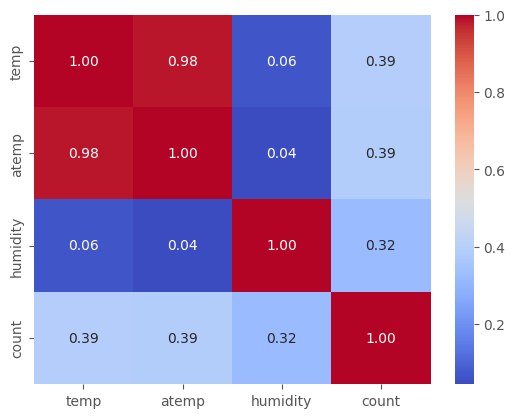

In [287]:
df_corr = abs(train.corr())

# plt.figure(figsize=(15,10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')

#### 다중공선성 처리

In [288]:
print(f'before: {train.shape} / {test.shape}')

drop_cols = ['atemp']

train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

print(f'after: {train.shape} / {test.shape}')

before: (10886, 20) / (6493, 19)
after: (10886, 19) / (6493, 18)


<Axes: >

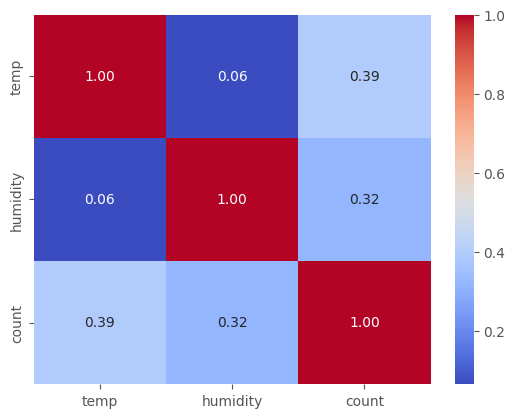

In [289]:
df_corr = abs(train.corr())

# plt.figure(figsize=(15,10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')

### 결측치(windspeed)

In [290]:
train['windspeed'].describe()

count     10886.0
unique       28.0
top           0.0
freq       1313.0
Name: windspeed, dtype: float64

In [291]:
train['windspeed'].value_counts()[:5]

0.0        1313
8.9981     1120
11.0014    1057
12.998     1042
7.0015     1034
Name: windspeed, dtype: int64

In [292]:
def predict_windspeed(p_train, p_test):
    print(f'before: {p_train.shape} / {p_test.shape}')

    train_wind0 = p_train.loc[p_train['windspeed'] == 0]
    train_wind_not0 = p_train.loc[p_train['windspeed'] != 0]
    test_wind0 = p_test.loc[p_test['windspeed'] == 0]
    test_wind_not0 = p_test.loc[p_test['windspeed'] != 0]

    # wind_cols = list(abs(p_train.corr())['windspeed'].sort_values().index)
    wind_cols = list(p_train.columns)
    wind_cols.remove('count')
    wind_cols.remove('windspeed')
    print(f'len(wind_cols): {len(wind_cols)}')

    # training
    train_wind_not0['windspeed'] = train_wind_not0['windspeed'].astype('str')
    wind_model = LGBMClassifier(random_state=args.SEED, verbose=-1)
    wind_model.fit(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    score = wind_model.score(train_wind_not0[wind_cols], train_wind_not0['windspeed'])
    print(f'score: {score}')

    # predict
    train_wind0['windspeed'] = wind_model.predict(train_wind0[wind_cols])
    test_wind0['windspeed'] = wind_model.predict(test_wind0[wind_cols])

    # concat
    _train = train_wind_not0.append(train_wind0)
    _train['windspeed'] = _train['windspeed'].astype('category')
    _train.reset_index(drop=True, inplace=True)
    _test = test_wind_not0.append(test_wind0)
    _test['windspeed'] = _test['windspeed'].astype('category')
    _test.reset_index(drop=True, inplace=True)

    _train = _train.sort_values(by=['year', 'month', 'day', 'hour'])
    _test = _test.sort_values(by=['year', 'month', 'day', 'hour'])
    print(f'after: {_train.shape} / {_test.shape}')
    return _train, _test

In [293]:
drop_cols = ['datetime']

print(f'before: {train.shape} / {test.shape}')
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)
print(f'after: {train.shape} / {test.shape}')

before: (10886, 19) / (6493, 18)
after: (10886, 18) / (6493, 17)


In [294]:
train.head(2)

,workingday,weather,temp,humidity,windspeed,count,year,month,day,dayofweek,hour,cat_year_hour,cat_month_hour,cat_workingday_hour,cat_year_workingday_weather,cat_year_workingday_hour,cat_year_month_hour,cat_year_month_workingday_hour
0,0,1,9.84,81,0.0,16,2011,1,1,5,0,cat_2011_0,cat_1_0,cat_0_0,cat_2011_0_1,cat_2011_0_0,cat_2011_1_0,cat_2011_1_0_0
1,0,1,9.02,80,0.0,40,2011,1,1,5,1,cat_2011_1,cat_1_1,cat_0_1,cat_2011_0_1,cat_2011_0_1,cat_2011_1_1,cat_2011_1_0_1


In [295]:
reset_seeds()

train, test = predict_windspeed(train, test)

before: (10886, 18) / (6493, 17)
len(wind_cols): 16
score: 0.08116577875274208
after: (10886, 18) / (6493, 17)


In [296]:
train.head(2)

,workingday,weather,temp,humidity,windspeed,count,year,month,day,dayofweek,hour,cat_year_hour,cat_month_hour,cat_workingday_hour,cat_year_workingday_weather,cat_year_workingday_hour,cat_year_month_hour,cat_year_month_workingday_hour
9573,0,1,9.84,81,31.0009,16,2011,1,1,5,0,cat_2011_0,cat_1_0,cat_0_0,cat_2011_0_1,cat_2011_0_0,cat_2011_1_0,cat_2011_1_0_0
9574,0,1,9.02,80,23.9994,40,2011,1,1,5,1,cat_2011_1,cat_1_1,cat_0_1,cat_2011_0_1,cat_2011_0_1,cat_2011_1_1,cat_2011_1_0_1


In [297]:
train['windspeed'].describe()

count      10886
unique        27
top       6.0032
freq        1358
Name: windspeed, dtype: object

## Feature Slection

### split data

In [298]:
y_train = train[args.target_col]
x_train = train.drop([args.target_col], axis=1)

x_train.shape, y_train.shape

((10886, 17), (10886,))

In [299]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y_train, shuffle=True, random_state=args.SEED)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((8164, 17), (2722, 17), (8164,), (2722,))

## modeling

In [300]:
reset_seeds()

modelv1 = LGBMRegressor(random_state=args.SEED)
modelv1.fit(x_tr, y_tr)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 17
[LightGBM] [Info] Start training from score 191.339784


LGBMRegressor(random_state=42)

### prediction

In [301]:
reset_seeds()

score = modelv1.score(x_tr, y_tr)

pred = modelv1.predict(x_te)
rmsle_score = rmsle(y_te, pred)

print(f'{score:.2f} / {rmsle_score:.2f}')

0.98 / 0.37


<Axes: ylabel='Density'>

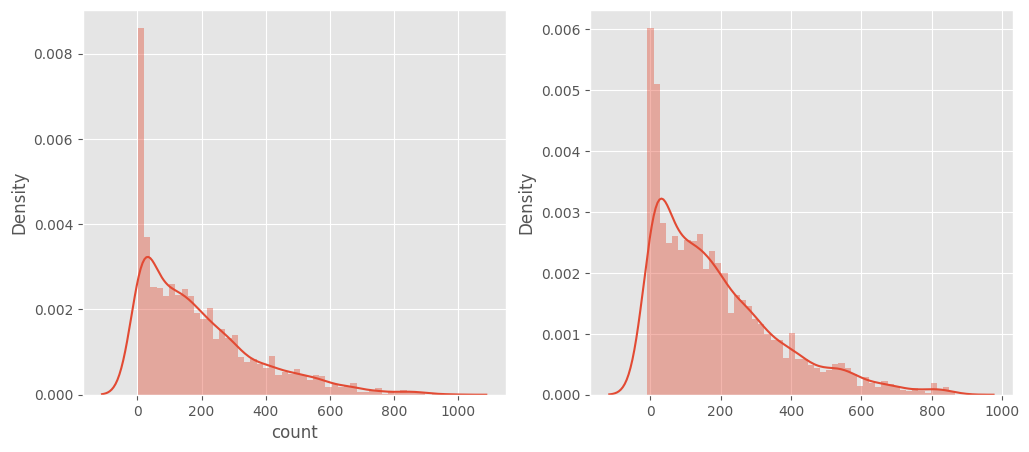

In [302]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_te, ax=ax1, bins=50)
sns.distplot(pred, ax=ax2, bins=50)

Text(0, 0.5, 'prediction')

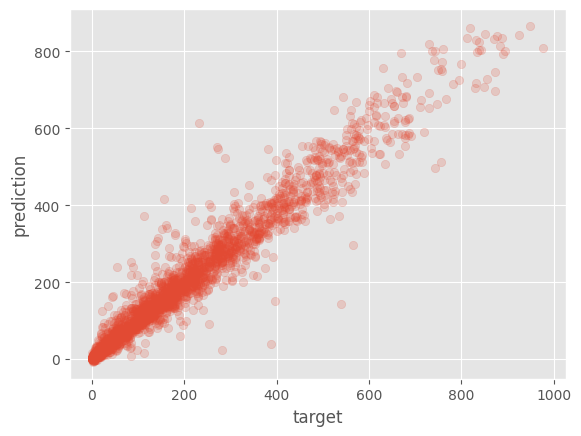

In [303]:
plt.scatter(y_te, pred, alpha=0.2)
plt.xlabel('target')
plt.ylabel('prediction')

### plot_importance

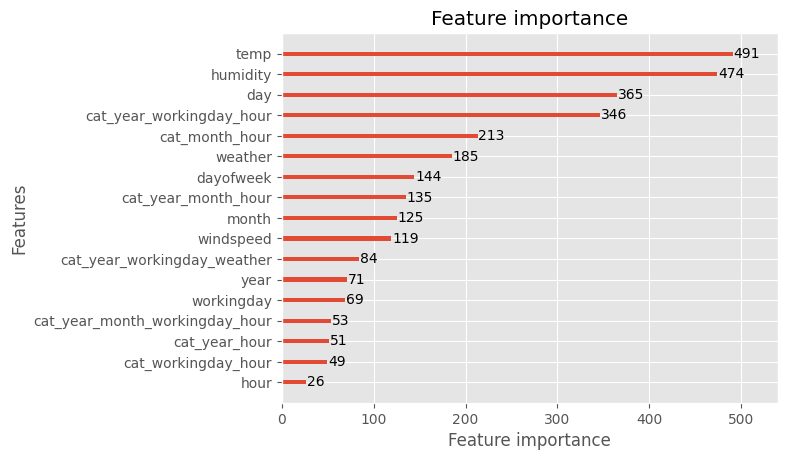

In [304]:
plot_importance(modelv1)
plt.show()

Text(0.5, 1.0, 'Permutation Importance')

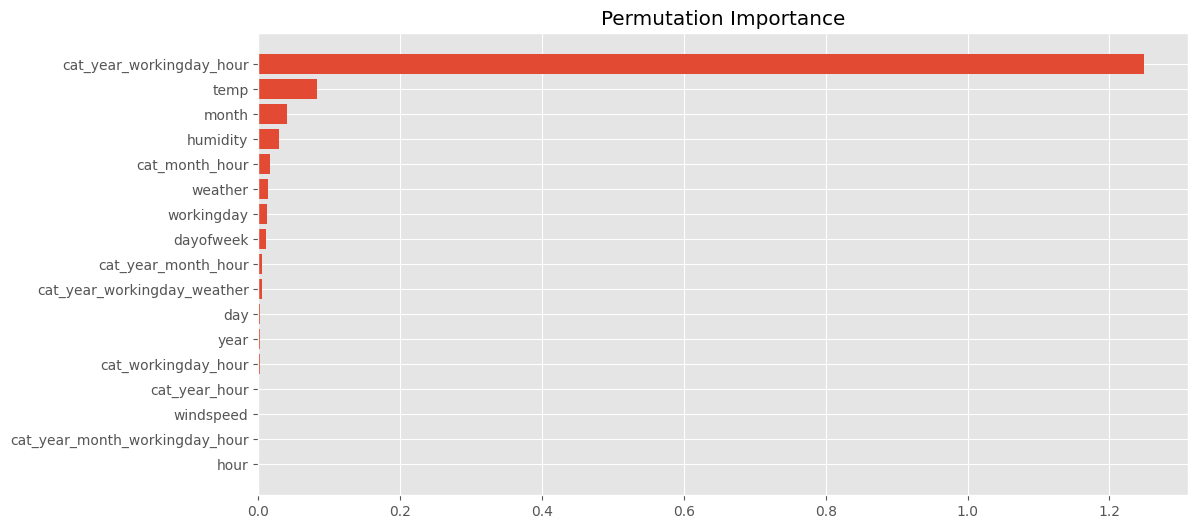

In [305]:
reset_seeds()

perm_importance = permutation_importance(modelv1, x_te, y_te, n_repeats=10, random_state=args.SEED)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_te.columns)[sorted_idx])
plt.title('Permutation Importance')

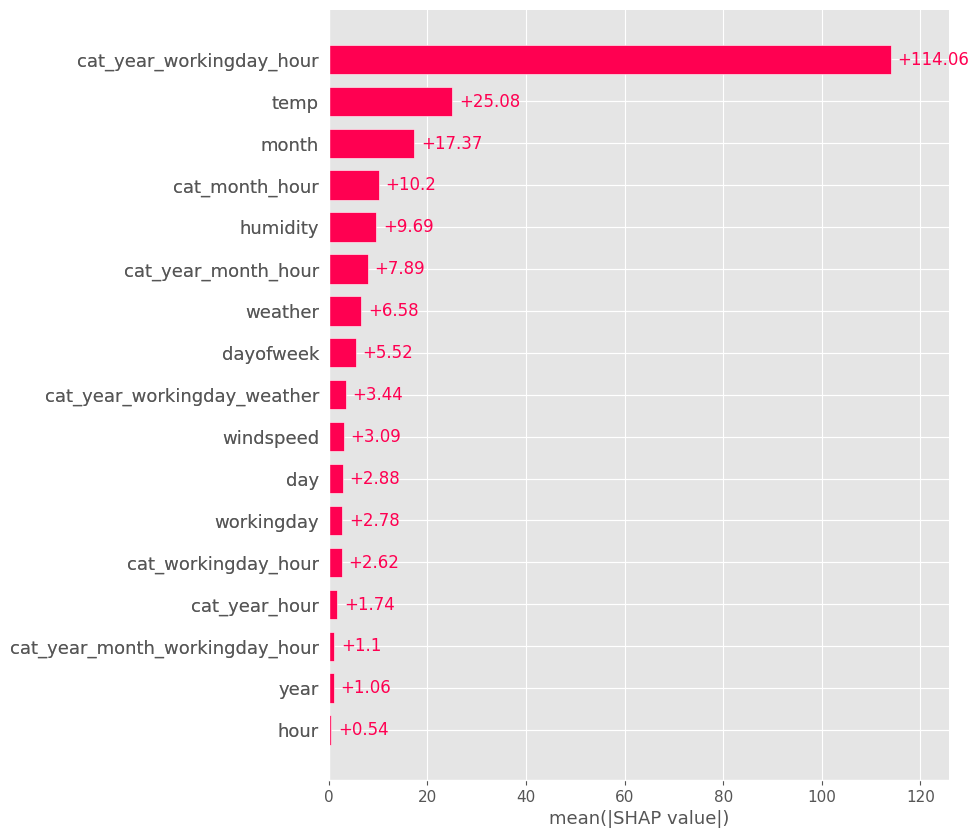

In [306]:
reset_seeds()

explainer = shap.Explainer(modelv1)
shap_values = explainer(x_te)
shap.plots.bar(shap_values, max_display=x_te.shape[0])


### result

In [307]:
modelv1_result = {
    'model':'modelv1',
    'score':score,
    'rmsle_score':rmsle_score,
    'prediction': modelv1.predict(test)
}

modelv1_result

{'model': 'modelv1',
 'score': 0.9811009286943649,
 'rmsle_score': 0.3661298715639016,
 'prediction': array([ 12.90896315,   6.94758566,   3.54843262, ..., 175.98449478,
        124.70413704,  78.60298112])}

In [308]:
args.result_list.append(modelv1_result)

In [309]:
args.result_list

[{'model': 'base_model',
  'score': 0.9741097629020183,
  'rmsle_score': 0.43299291095628983,
  'prediction': array([  9.76272451,   2.60976455,   1.50624777, ..., 163.16752831,
         103.57051757,  71.99775386])},
 {'model': 'modelv1',
  'score': 0.9811009286943649,
  'rmsle_score': 0.3661298715639016,
  'prediction': array([ 12.90896315,   6.94758566,   3.54843262, ..., 175.98449478,
         124.70413704,  78.60298112])}]

# 결과 비교

In [318]:
df_result = pd.DataFrame(args.result_list)

df_result = df_result.sort_values(by=['rmsle_score']).reset_index(drop=True)
df_result

,model,score,rmsle_score,prediction
0,modelv1,0.981101,0.366130,"[12.908963148726366, 6.947585662573311, 3.5484..."
1,base_model,0.974110,0.432993,"[9.762724508382052, 2.6097645497616946, 1.5062..."


# Submit

In [323]:
df_result.iloc[0]

model                                                    modelv1
score                                                   0.981101
rmsle_score                                              0.36613
prediction     [12.908963148726366, 6.947585662573311, 3.5484...
Name: 0, dtype: object

In [332]:
test_predict = df_result.iloc[0]['prediction']
test_predict = test_predict.astype(int)

test_predict.shape

(6493,)

In [333]:
submission = pd.read_csv(args.submission_path)

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


In [334]:
submission['count'] = test_predict

print(submission.shape)
submission.head(3)

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12
1,2011-01-20 01:00:00,6
2,2011-01-20 02:00:00,3


## 예측 데이터 검증

In [335]:
submission['count'].describe()

count    6493.000000
mean      186.487294
std       174.403531
min        -9.000000
25%        43.000000
50%       142.000000
75%       280.000000
max       901.000000
Name: count, dtype: float64

In [336]:
submission[submission['count'] < 0].shape

(40, 2)

In [337]:
submission['count'] = submission['count'].map(lambda x: x if x>0 else 0)
submission['count'].describe()

count    6493.000000
mean      186.501925
std       174.387733
min         0.000000
25%        43.000000
50%       142.000000
75%       280.000000
max       901.000000
Name: count, dtype: float64

In [339]:
rmsle_score = df_result.iloc[0]['rmsle_score']
rmsle_score

0.3661298715639016

In [340]:
args.submission_file
submission.to_csv(args.submission_file.format(rmsle_score), index=False)

Overfitting이 발생된 것으로 예상됨

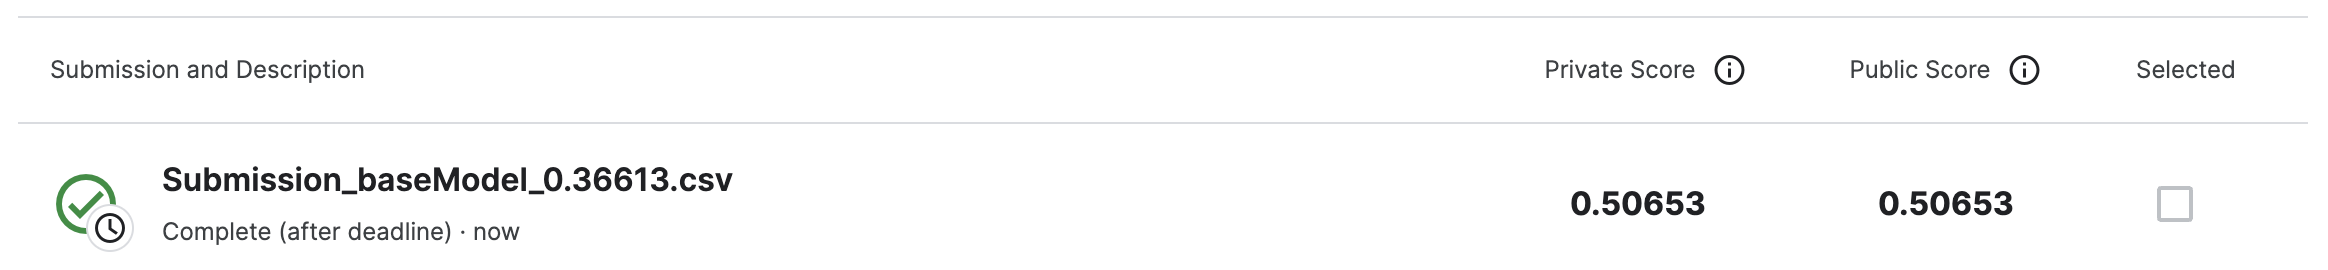